In [13]:
import os
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from collections import Counter
import matplotlib.pyplot as plt
from captum.attr import IntegratedGradients
from captum.attr import LayerIntegratedGradients
from captum.attr import visualization as viz
from captum.attr import LayerGradCam
import numpy as np

In [2]:
#Reading in the train and validation datasets
train_dir = 'dogs-vs-cats-subset\subset\\train'
validation_dir = 'dogs-vs-cats-subset\subset\\validation'

<>:1: SyntaxWarning: invalid escape sequence '\s'
<>:2: SyntaxWarning: invalid escape sequence '\s'
<>:1: SyntaxWarning: invalid escape sequence '\s'
<>:2: SyntaxWarning: invalid escape sequence '\s'
C:\Users\acer\AppData\Local\Temp\ipykernel_5784\1091088894.py:1: SyntaxWarning: invalid escape sequence '\s'
  train_dir = 'dogs-vs-cats-subset\subset\\train'
C:\Users\acer\AppData\Local\Temp\ipykernel_5784\1091088894.py:2: SyntaxWarning: invalid escape sequence '\s'
  validation_dir = 'dogs-vs-cats-subset\subset\\validation'


#
Without Augmentation

In [3]:
#Defining the model architecture for a non-augmented input setup
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        #Conv layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3)  
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)  
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3)  
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3)  
        
        #MaxPool layers
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        #FC layers
        self.fc1 = nn.Linear(128 * 7 * 7, 512)  
        self.fc2 = nn.Linear(512, 1)
        
    def forward(self, x):
        #Defining the forward pass
        x = self.pool(F.relu(self.conv1(x))) 
        x = self.pool(F.relu(self.conv2(x)))  
        x = self.pool(F.relu(self.conv3(x)))  
        x = self.pool(F.relu(self.conv4(x)))  
        
        x = torch.flatten(x, 1)  
        
        x = F.relu(self.fc1(x))
        #Sigmoid as head for binary classification task 
        x = torch.sigmoid(self.fc2(x))
        
        return x

In [4]:
#Calling the model
model = CNNModel()

In [5]:
#Model parametres and layers
summary(model, (3,150,150))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 148, 148]             896
         MaxPool2d-2           [-1, 32, 74, 74]               0
            Conv2d-3           [-1, 64, 72, 72]          18,496
         MaxPool2d-4           [-1, 64, 36, 36]               0
            Conv2d-5          [-1, 128, 34, 34]          73,856
         MaxPool2d-6          [-1, 128, 17, 17]               0
            Conv2d-7          [-1, 128, 15, 15]         147,584
         MaxPool2d-8            [-1, 128, 7, 7]               0
            Linear-9                  [-1, 512]       3,211,776
           Linear-10                    [-1, 1]             513
Total params: 3,453,121
Trainable params: 3,453,121
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.26
Forward/backward pass size (MB): 11.53
Params size (MB): 13.17
Estim

In [6]:
#BCE Loss
criterion = nn.BCELoss()

#RMSprop
optimizer = optim.RMSprop(model.parameters(), lr=1e-4)

In [7]:
#Resizing training images to 150*150, converting to tensor and rescaling to [0,1]
train_transform = transforms.Compose([
    transforms.Resize((150, 150)),  
    transforms.ToTensor(),          
])

#Resizing val images to 150*150, converting to tensor and rescaling to [0,1]
validation_transform = transforms.Compose([
    transforms.Resize((150, 150)),  
    transforms.ToTensor(),          
])

#Loading images
train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
validation_dataset = datasets.ImageFolder(validation_dir, transform=validation_transform)

#Data loaders
train_loader = DataLoader(train_dataset, batch_size=20, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=20, shuffle=False)

#Counting samples from each class in training dataset
train_class_count = Counter()

for inputs, labels in train_loader:
    train_class_count.update(labels.tolist())  

print("For training dataset:\n")
print(f"Number of examples in class 0: {train_class_count[0]}")
print(f"Number of examples in class 1: {train_class_count[1]}\n")

#Counting samples from each class in training dataset
val_class_count = Counter()

for inputs, labels in validation_loader:
    val_class_count.update(labels.tolist())  

print("For validation dataset:\n")
print(f"Number of examples in class 0: {val_class_count[0]}")
print(f"Number of examples in class 1: {val_class_count[1]}\n")

#Checking training labels size
for inputs, labels in train_loader:
    print(f"Batch size: {inputs.shape}, Labels: {labels.shape}")
    break

For training dataset:

Number of examples in class 0: 1000
Number of examples in class 1: 1000

For validation dataset:

Number of examples in class 0: 500
Number of examples in class 1: 500

Batch size: torch.Size([20, 3, 150, 150]), Labels: torch.Size([20])


In [8]:
#Training loop

#Display device training being performed on
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model.to(device)

#List to store metrics
train_acc_list = []
val_acc_list = []
train_loss_list = []
val_loss_list = []

#Number of epochs and steps per epoch
num_epochs = 30
steps_per_epoch = 100  
validation_steps = 50

for epoch in range(num_epochs):
    #Training phase
    model.train() 
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for step, (inputs, labels) in enumerate(train_loader):
        if step >= steps_per_epoch: 
            break
        
        inputs, labels = inputs.to(device), labels.to(device).float()

        optimizer.zero_grad()

        #Forward pass
        outputs = model(inputs).squeeze() 

        #Compute step train loss
        loss = criterion(outputs, labels)
        
        #Backward pass
        loss.backward()
        optimizer.step()

        #Update epoch train loss
        running_loss += loss.item()

        #Compute accuracy with sigmoid threshold
        predicted = (outputs > 0.5).float()  
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    #Average training loss and accuracy for epoch
    epoch_loss = running_loss / steps_per_epoch
    epoch_acc = correct_train / total_train
    train_loss_list.append(epoch_loss)
    train_acc_list.append(epoch_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}] - Training Loss: {epoch_loss:.4f}, Training Accuracy: {epoch_acc:.4f}")

    #Validation phase
    model.eval()  
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():  
        for step, (inputs, labels) in enumerate(validation_loader):
            if step >= validation_steps:  
                break

            inputs, labels = inputs.to(device), labels.to(device).float()

            #Forward pass
            outputs = model(inputs).squeeze()

            #Compute step validation loss and add to epoch val loss
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            #Compute validation accuracy
            predicted = (outputs > 0.5).float()
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

    #Average validation loss and accuracy for epoch
    val_loss /= validation_steps
    val_acc = correct_val / total_val
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}] - Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")

cpu
Epoch [1/30] - Training Loss: 0.6922, Training Accuracy: 0.5210
Epoch [1/30] - Validation Loss: 0.6866, Validation Accuracy: 0.5320
Epoch [2/30] - Training Loss: 0.6800, Training Accuracy: 0.5655
Epoch [2/30] - Validation Loss: 0.6576, Validation Accuracy: 0.6090
Epoch [3/30] - Training Loss: 0.6479, Training Accuracy: 0.6300
Epoch [3/30] - Validation Loss: 0.6292, Validation Accuracy: 0.6490
Epoch [4/30] - Training Loss: 0.6226, Training Accuracy: 0.6635
Epoch [4/30] - Validation Loss: 0.6079, Validation Accuracy: 0.6730
Epoch [5/30] - Training Loss: 0.6033, Training Accuracy: 0.6860
Epoch [5/30] - Validation Loss: 0.6051, Validation Accuracy: 0.6600
Epoch [6/30] - Training Loss: 0.5831, Training Accuracy: 0.7035
Epoch [6/30] - Validation Loss: 0.6178, Validation Accuracy: 0.6390
Epoch [7/30] - Training Loss: 0.5680, Training Accuracy: 0.7200
Epoch [7/30] - Validation Loss: 0.6601, Validation Accuracy: 0.6350
Epoch [8/30] - Training Loss: 0.5538, Training Accuracy: 0.7265
Epoch [8

In [9]:
#Save the model
torch.save(model.state_dict(), 'cats_and_dogs_small_11.pth')

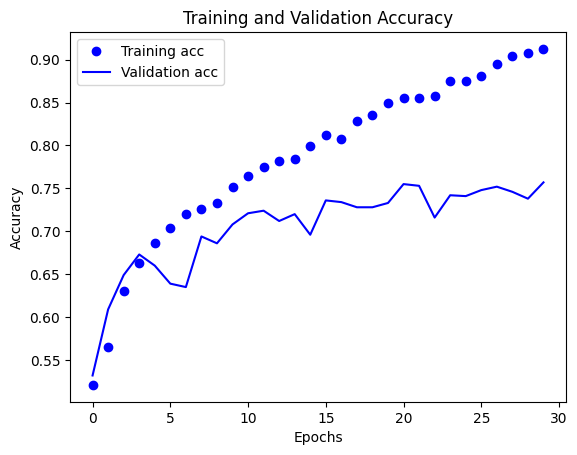

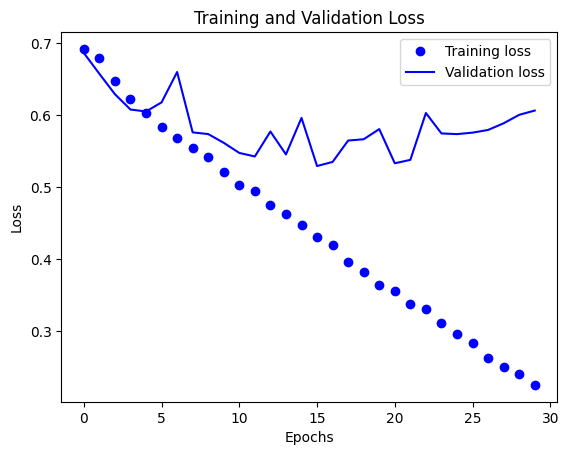

In [10]:
epochs = range(num_epochs)

#Plot accuracy
plt.plot(epochs, train_acc_list, 'bo', label='Training acc')
plt.plot(epochs, val_acc_list, 'b', label='Validation acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#Plot loss
plt.figure()
plt.plot(epochs, train_loss_list, 'bo', label='Training loss')
plt.plot(epochs, val_loss_list, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#
With Augmentation

In [13]:
#Transformations for augmentation
data_transforms = transforms.Compose([
    transforms.RandomRotation(40),
    transforms.RandomAffine(degrees=0, translate=(0.2, 0.2), shear=0.2, scale=None),
    transforms.RandomResizedCrop(150, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])


In [14]:
#Applying transforms to a randomly selected image from class cats

train_cats_dir = 'dogs-vs-cats-subset\subset\\train\cats'  
fnames = [os.path.join(train_cats_dir, fname) for fname in os.listdir(train_cats_dir)]
img_path = fnames[3]
img = Image.open(img_path)
x = data_transforms(img)
x = x.unsqueeze(0)  


<>:2: SyntaxWarning: invalid escape sequence '\s'
<>:2: SyntaxWarning: invalid escape sequence '\s'
C:\Users\acer\AppData\Local\Temp\ipykernel_27160\1522168300.py:2: SyntaxWarning: invalid escape sequence '\s'
  train_cats_dir = 'dogs-vs-cats-subset\subset\\train\cats'  # Replace with your actual directory path


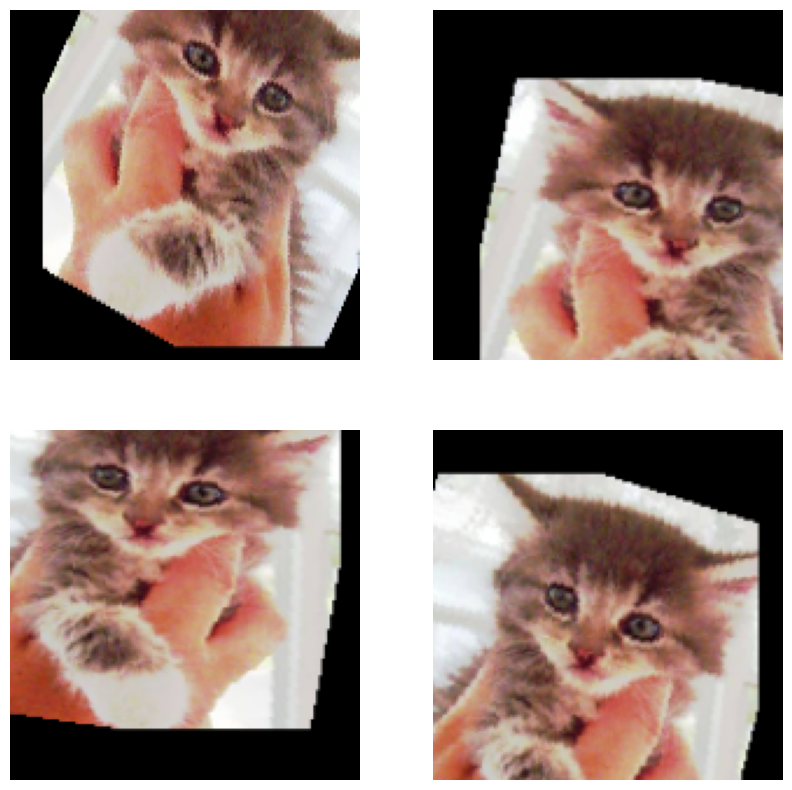

In [15]:
#Displaying 4 differently augmented outputs of the same image

plt.figure(figsize=(10, 10))


for i in range(4):
    augmented_image = data_transforms(img).numpy()
    augmented_image = augmented_image.transpose((1, 2, 0))
    plt.subplot(2, 2, i + 1)
    plt.imshow(augmented_image)
    plt.axis('off')

plt.show()


In [3]:
#Definging model architecture compatible with augmented inputs
class AugCNN(nn.Module):
    def __init__(self):
        super(AugCNN, self).__init__()
        
        #Conv layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3) 
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3) 
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3) 
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3) 
        
        #MaxPool layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        #Dropout layer
        self.dropout = nn.Dropout(p=0.5)
        
        #FC layers
        self.fc1 = nn.Linear(128 * 7 * 7, 512)  
        self.fc2 = nn.Linear(512, 1)  
        
    #Forward pass
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) 
        x = self.pool(F.relu(self.conv2(x))) 
        x = self.pool(F.relu(self.conv3(x))) 
        x = self.pool(F.relu(self.conv4(x))) 
        
        x = torch.flatten(x, 1)  
        
        x = self.dropout(x)  
        
        x = F.relu(self.fc1(x)) 
        #Sigmoid for binary classification 
        x = torch.sigmoid(self.fc2(x))  
        
        return x

#Model instance
model = AugCNN()

#Optimizer and loss function
optimizer = optim.RMSprop(model.parameters(), lr=1e-4)
criterion = nn.BCELoss()  

In [17]:
#Model parameters and layers
summary(model, (3,150,150))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 148, 148]             896
         MaxPool2d-2           [-1, 32, 74, 74]               0
            Conv2d-3           [-1, 64, 72, 72]          18,496
         MaxPool2d-4           [-1, 64, 36, 36]               0
            Conv2d-5          [-1, 128, 34, 34]          73,856
         MaxPool2d-6          [-1, 128, 17, 17]               0
            Conv2d-7          [-1, 128, 15, 15]         147,584
         MaxPool2d-8            [-1, 128, 7, 7]               0
           Dropout-9                 [-1, 6272]               0
           Linear-10                  [-1, 512]       3,211,776
           Linear-11                    [-1, 1]             513
Total params: 3,453,121
Trainable params: 3,453,121
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.26
Forw

In [18]:
#Transformations to apply on training images 
train_transforms = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.RandomRotation(40),
    transforms.RandomAffine(degrees=0, translate=(0.2, 0.2), shear=20),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

#Transformations on validation images should be devoid of augmentation
validation_transforms = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
])

train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
validation_dataset = datasets.ImageFolder(validation_dir, transform=validation_transforms)

#Data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=32, shuffle=False)

#Counting instances of samples from both classes in training set
train_class_count = Counter()

for inputs, labels in train_loader:
    train_class_count.update(labels.tolist())  
print("For training dataset:\n")
print(f"Number of examples in class 0: {train_class_count[0]}")
print(f"Number of examples in class 1: {train_class_count[1]}\n")

#Counting instances of samples from both classes in validation set
val_class_count = Counter()

for inputs, labels in validation_loader:
    val_class_count.update(labels.tolist())  
print("For validation dataset:\n")
print(f"Number of examples in class 0: {val_class_count[0]}")
print(f"Number of examples in class 1: {val_class_count[1]}\n")

#Training data input shape
for inputs, labels in train_loader:
    print(f"Batch size: {inputs.shape}, Labels: {labels.shape}")
    break

For training dataset:

Number of examples in class 0: 1000
Number of examples in class 1: 1000

For validation dataset:

Number of examples in class 0: 500
Number of examples in class 1: 500

Batch size: torch.Size([32, 3, 150, 150]), Labels: torch.Size([32])


In [19]:
#Training loop

#Display device training being performed on
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model.to(device)

#List to store metrics
train_acc_list = []
val_acc_list = []
train_loss_list = []
val_loss_list = []

#Number of epochs and steps per epoch
num_epochs = 30
steps_per_epoch = 100  
validation_steps = 50

for epoch in range(num_epochs):
    #Training phase
    model.train() 
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for step, (inputs, labels) in enumerate(train_loader):
        if step >= steps_per_epoch: 
            break
        
        inputs, labels = inputs.to(device), labels.to(device).float()

        optimizer.zero_grad()

        #Forward pass
        outputs = model(inputs).squeeze() 

        #Compute step train loss
        loss = criterion(outputs, labels)
        
        #Backward pass
        loss.backward()
        optimizer.step()

        #Update epoch train loss
        running_loss += loss.item()

        #Compute accuracy with sigmoid threshold
        predicted = (outputs > 0.5).float()  
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    #Average training loss and accuracy for epoch
    epoch_loss = running_loss / steps_per_epoch
    epoch_acc = correct_train / total_train
    train_loss_list.append(epoch_loss)
    train_acc_list.append(epoch_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}] - Training Loss: {epoch_loss:.4f}, Training Accuracy: {epoch_acc:.4f}")

    #Validation phase
    model.eval()  
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():  
        for step, (inputs, labels) in enumerate(validation_loader):
            if step >= validation_steps:  
                break

            inputs, labels = inputs.to(device), labels.to(device).float()

            #Forward pass
            outputs = model(inputs).squeeze()

            #Compute step validation loss and add to epoch val loss
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            #Compute validation accuracy
            predicted = (outputs > 0.5).float()
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

    #Average validation loss and accuracy for epoch
    val_loss /= validation_steps
    val_acc = correct_val / total_val
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}] - Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")

cpu
AugCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=6272, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=1, bias=True)
)
Epoch [1/100] - Training Loss: 0.6941, Training Accuracy: 0.5055
Epoch [1/100] - Validation Loss: 0.6931, Validation Accuracy: 0.4940
Epoch [2/100] - Training Loss: 0.6929, Training Accuracy: 0.5207
Epoch [2/100] - Validation Loss: 0.6887, Validation Accuracy: 0.5262
Epoch [3/100] - Training Loss: 0.6876, Training Accuracy: 0.5499
Epoch [3/100] - Validation Loss: 0.6918, Validation Accuracy: 0.5141
Epoch [4/100] - Training Loss: 0.6813, Training Accuracy: 0.5585
Epoch [4/100] - Valida

In [20]:
#Saving the model
torch.save(model.state_dict(), 'cats_and_dogs_small_21.pth')

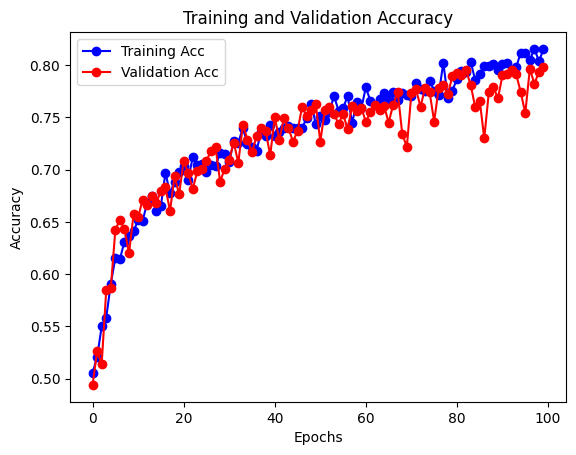

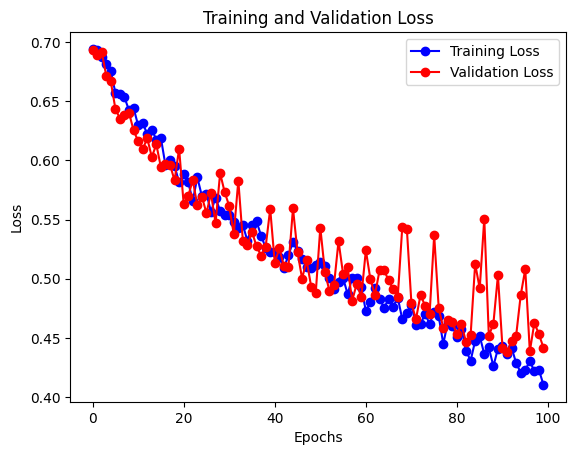

In [21]:
#Plot training & validation accuracy
plt.plot(range(num_epochs), train_acc_list, 'bo-', label='Training Acc')
plt.plot(range(num_epochs), val_acc_list, 'ro-', label='Validation Acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#Plot training & validation loss
plt.plot(range(num_epochs), train_loss_list, 'bo-', label='Training Loss')
plt.plot(range(num_epochs), val_loss_list, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


#
IntegratedGradients and GradCAM

In [4]:
#Model archetecture instance + loading saved weights + putting model on eval mode
model = AugCNN()
model.load_state_dict(torch.load('cats_and_dogs_small_21.pth'))
model.eval()

C:\Users\acer\AppData\Local\Temp\ipykernel_5784\3088349517.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('cats_and_dogs_small_21.pth')

AugCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=6272, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=1, bias=True)
)

<>:7: SyntaxWarning: invalid escape sequence '\s'
<>:7: SyntaxWarning: invalid escape sequence '\s'
C:\Users\acer\AppData\Local\Temp\ipykernel_5784\3932400168.py:7: SyntaxWarning: invalid escape sequence '\s'
  img = Image.open('dogs-vs-cats-subset\subset\\validation\cats\cat.1002.jpg')


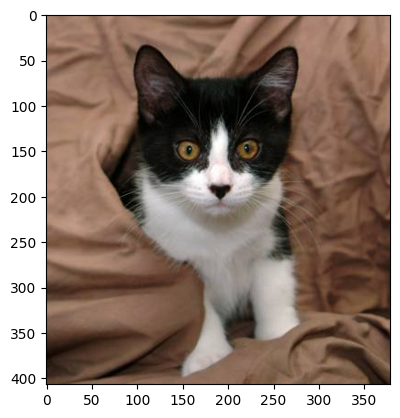

In [39]:
#Preprocessing validation image
preprocess = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
])


img = Image.open('dogs-vs-cats-subset\subset\\validation\cats\cat.1002.jpg')
img_tensor = preprocess(img)
img_tensor = img_tensor.unsqueeze(0)

plt.imshow(img)

In [7]:
#Checking output score and class label
with torch.no_grad():
    output = model(img_tensor)
    predicted_class = 1 if output >= 0.5 else 0 

print(output,predicted_class)

tensor([[0.2776]]) 0


##
Integrated Gradients

Integrated Gradients works by computing the contribution of each input feature by integrating the gradients of the model's output with respect to the input, while gradually changing the input from a baseline to the actual input.

Let f(x) be the output of a model with input x = [x1,x2,....,xd] where number of features = d = number of pixels for this task.  
Since we did not explicitly define a baseline, 𝑥′ = [0,0,.....,0] pertaining to an all black image will be considered the baseline.  
The contributions of input features are calculated by interpolating between the baseline x′ and the actual input 𝑥 using x(α) = x′ + α(x−x′) where α∈[0,1] determines how far along the path between 𝑥′ and 𝑥 the interpolation is.  
The integral of the gradients along the path between 𝑥′ and x gives the attributions for each feature. For each feature i, the attribution is computed as:  
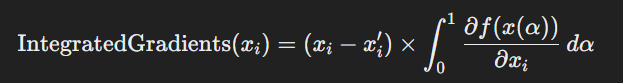    
  
Interpreting Integrated Gradients: Features that cause a large change in the output when travelling from the baseline to the input are given higher attribution. These are ultimately percieved as the most important features.

In [41]:
#Calculating Integrated gradient attributions
ig = IntegratedGradients(model)

attributions = ig.attribute(img_tensor, target=predicted_class)
print(attributions.shape)

torch.Size([1, 3, 150, 150])


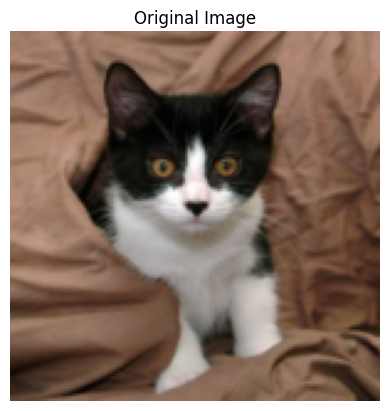

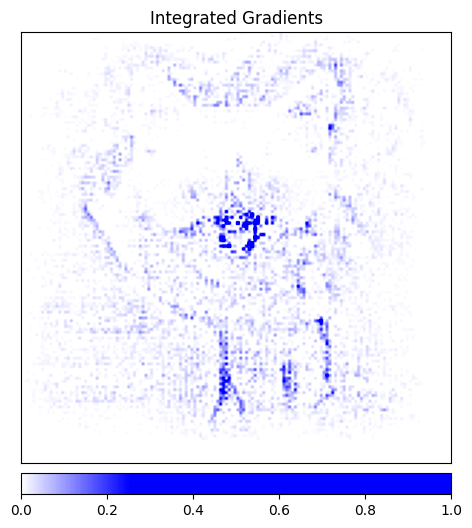

In [42]:
#Show the original image
plt.imshow(np.transpose(img_tensor.squeeze().cpu().detach().numpy(), (1, 2, 0)))
plt.axis('off')
plt.title("Original Image")
plt.show()

#Define the color map for visualization
default_cmap = viz.LinearSegmentedColormap.from_list('custom blue',
    [(0, '#ffffff'), (0.25, '#0000ff'), (1, '#0000ff')], N=256)

#Visualize the attributions
_ = viz.visualize_image_attr(np.transpose(attributions.squeeze().cpu().detach().numpy(), (1, 2, 0)),
                              np.transpose(img_tensor.squeeze().cpu().detach().numpy(), (1, 2, 0)),
                              method='heat_map',
                              cmap=default_cmap,
                              show_colorbar=True,
                              sign='positive',
                              title='Integrated Gradients')

plt.show()

Observations:
1. The heatmap suggests the model was efficiently able to outline the foreground element of the image.
2. The heatmap also suggests that the model focused heavily on the nose section of the cat and to a somewhat comparable degree to the paws and general outline of the cat to make a prediction.

##
GradCAM 

Steps to calculate GradCAM attributions for a particular layer in a CNN:
1. After the forward pass through the layer for an image I, let the output for the class c be yc=fc(I) where fc is the function learned by the network for class c at the layer. 
2. Let Al of dimension [K×H×W] epresent the feature maps from the convolutional layer l, we compute the gradient of yc wrt Al. This gradient signifies how much the feature map at location [hxw] in channel [k] contributes to the class score yc.  
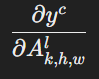
3. We then compute the global average of the gradients over the spatial dimensions [HxW] for each channel [k], 𝛼ck which represent the importance of feature map k for predicting class c.  
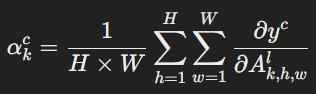
4. Next each feature map Alk is multiplied by its corresponding weight 𝛼ck and the weighted feature maps are summed together across all channels k. Then it is passed through a ReLU function because we are only interested in the regions that positively influence the class score.  
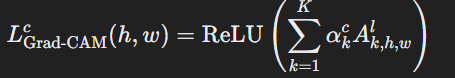
5. The 2D heatmap that can be created from the output of the ReLU function is then upsampled to the size of the original input image and overlayed onto it.

Interpreting a GradCAM heatmap: The regions of higher importance are highlighted in the heatmap and these regions are learned by the model as crucial information to make predictions for a given class c.
​
 



In [36]:
#Calculating GradCAM layer attributions for the last conv layer
gradcam = LayerGradCam(model, model.conv4)

layer_attributions = gradcam.attribute(img_tensor, target=predicted_class)
print(layer_attributions.shape)

torch.Size([1, 1, 15, 15])


torch.Size([1, 1, 15, 15])
torch.Size([1, 1, 150, 150])
torch.Size([1, 3, 150, 150])


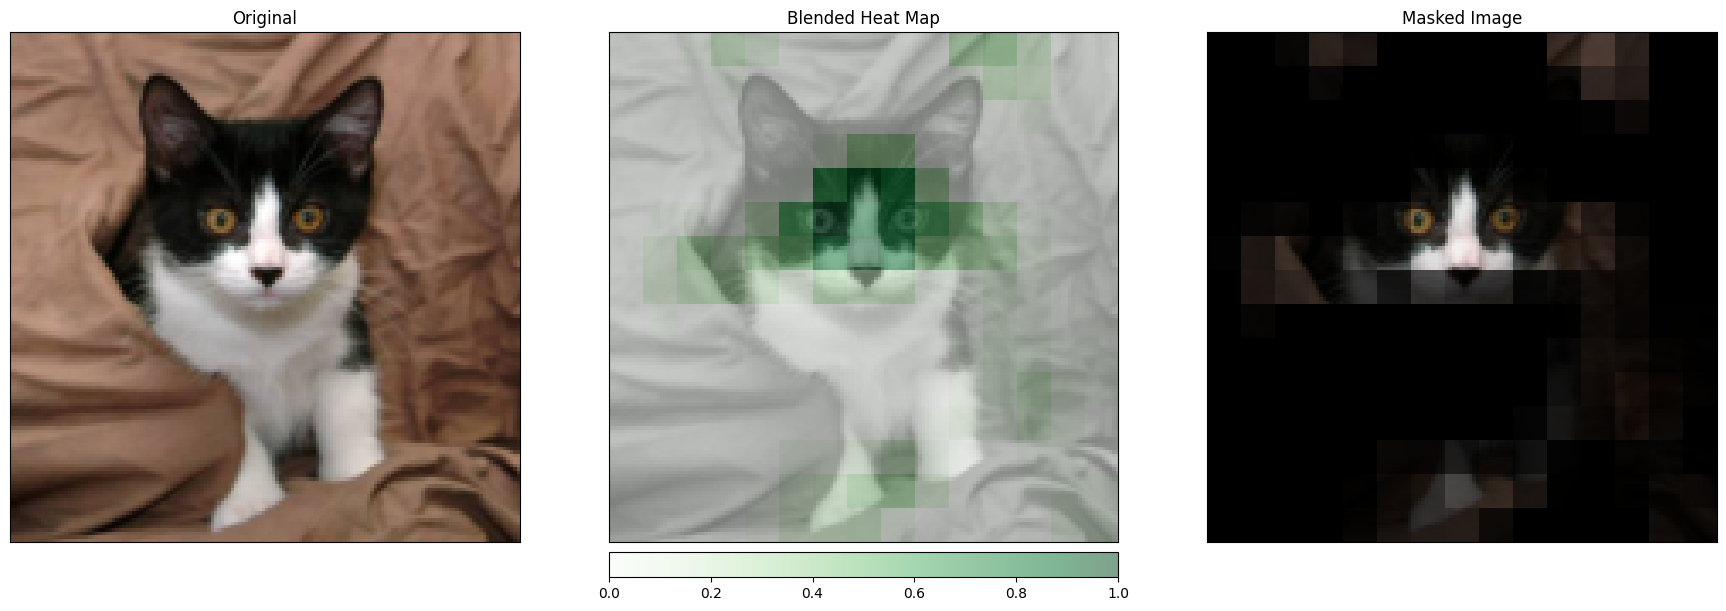

In [37]:
#Upsampling the attributions to match input size for plotting
upsamp_attr_lgc = LayerIntegratedGradients.interpolate(layer_attributions, img_tensor.shape[2:])

print(layer_attributions.shape)
print(upsamp_attr_lgc.shape)
print(img_tensor.shape)

# Visualizing the attributions
_ = viz.visualize_image_attr_multiple(
    upsamp_attr_lgc[0].cpu().permute(1,2,0).detach().numpy(),
    img_tensor.squeeze().permute(1,2,0).numpy(),
    ["original_image", "blended_heat_map", "masked_image"],
    ['all', 'positive', 'positive'],
    show_colorbar=True,
    titles=["Original", "Blended Heat Map", "Masked Image"],
    fig_size=(18, 6)
)

Observations:
1. As suggested by the heatmap and the masked image, the last layer of the model focuses on a centrally located distinct feature (the face) to make predictions.
2. It also focuses to a smaller degree on some regions in the background that could resonate with regions of importance seen in the training data.